<table>
    <tr>
        <td>
        <center>
        <font size="+1">If you haven't used BigQuery datasets on Kaggle previously, check out the <a href = "https://www.kaggle.com/rtatman/sql-scavenger-hunt-handbook/">Scavenger Hunt Handbook</a> kernel to get started.</font>
        </center>
        </td>
    </tr>
</table>

___ 

## Previous days:

* [**Day 1:** SELECT, FROM & WHERE](https://www.kaggle.com/rtatman/sql-scavenger-hunt-day-1/)
* [**Day 2:** GROUP BY, HAVING & COUNT()](https://www.kaggle.com/rtatman/sql-scavenger-hunt-day-2/)
* [**Day 3:** ORDER BY & Dates](https://www.kaggle.com/rtatman/sql-scavenger-hunt-day-3/)

____


## AS & WITH
___

So far we've learned how to use these clauses in our queries: 

    SELECT ... 
    FROM ...
    (WHERE) ...
    GROUP BY ...
    (HAVING) ...
    ORDER BY
By this point, our queries are getting pretty long, which can make them hard to puzzle out exactly what we're asking for.

We've also started using functions like EXTRACT() to get information out of dates or aggregate functions like COUNT(). You may have noticed, however, that the columns that we use these functions are are returned with names like `_f0` and `_f1`, which aren't very helpful.

Don't worry, though, we're going to learn how to get around both of these problems. Today, we're going to learn how to use AS and WITH to tidy up our queries and make them easier to read.

### AS
___

First, let's talk about the AS clause. AS lets you refer to the the columns generated by your queries with different names, which is also know as "aliasing". (If you use Python a lot you might already have used `as` for aliasing if you've ever done something like `import pandas as pd` or `imports seaborn as sns`.)

To use AS in SQL, you just insert it right after the name of the column you select. Here's an example of a query **without** an AS clause:  

        SELECT EXTRACT(DAY FROM column_with_timestamp), data_point_3
        FROM `bigquery-public-data.imaginary_dataset.imaginary_table`
And here's an example of the same query, but with AS.

        SELECT EXTRACT(DAY FROM column_with_timestamp) AS day,
                data_point_3 AS data
        FROM `bigquery-public-data.imaginary_dataset.imaginary_table`
Both of these queries will return the exact same table, but in the second query the columns returned will be called `day` and `data`, rather than the default names of `_f0` and `data_point_3`.

### WITH... AS
____

On its own, AS is a convenient way to make your code easier to read and tidy up the data returned by your query. It's even more powerful when combined with WITH in what's called a "common table expression" or CTE.

> **Common table expression**: A temporary table that you return within your query. You can then write queries against the new table you've created. CTE's only exist inside the query where you create them, though, so you can't reference them in later queries.

CTE's are very helpful for breaking up your queries into readable chunks and make it easier to follow what's going on in your code. 

Let's look at how to use them. We're going to be the same small Pets table that we've been working with previously, but now it includes information on the ages of all the different animals. These are in a column called "Years_old":

![](https://i.imgur.com/01s9TwR.png)

We might want to ask questions about older animals in particular. One way that we could do this is to create a CTE that only contains information about older animals and then write get information about it. So we can create a CTE which only contains information about animals more than five years old like this:

    # note that this query won't return anything!
    WITH Seniors AS 
            (
                SELECT ID, Name
                FROM `bigquery-public-data.pet_records.pets`
                WHERE Years_old > 5
            )
This will create the following temporary table that we can then refer to in the rest of our query, which only has the ID and Name of the animals that are seniors:

![](https://i.imgur.com/LBippKL.png)

If we wanted additional information about this table, we can write a query under it. So this query will create the CTE shown above, and then return all the ID's from it (in this case just 2 and 4).

    WITH Seniors AS 
            (
                SELECT ID, Name
                FROM `bigquery-public-data.pet_records.pets`
                WHERE Years_old > 5
            )
    SELECT ID
    FROM Seniors
We could do this without a CTE, but if this were the first part of a very long query, removing the CTE would make it much harder to follow.

## Example: How many Bitcoin transactions are made per month?
____

Now let's work through an example with a real dataset. Today, we're going to be working with a Bitcoin dataset (Bitcoin is a popular but volatile cryptocurrency). We're going to use a common table expression (CTE) to find out how many Bitcoin transactions were made per month for the entire timespan of this dataset.

First, just like the last three days, we need to get our environment set up:

In [1]:
# import package with helper functions 
import bq_helper

# create a helper object for this dataset
bitcoin_blockchain = bq_helper.BigQueryHelper(active_project="bigquery-public-data",
                                              dataset_name="bitcoin_blockchain")

Now we're going to write a query to get the number of transactions per month. One problem here is that this dataset uses timestamps rather than dates, and they're stored in this dataset as integers. We'll have to convert these into a format that BigQuery recognizes using TIMESTAMP_MILLIS(). We can do that using a CTE and then write a second part of the query against the new, temporary table we created. This has the advantage of breaking up our query into two, logical parts. 

* Convert the integer to a timestamp
* Get information on the date of transactions from the timestamp

You can see the query I used to do this below.

In [2]:
query = """ WITH time AS 
            (
                SELECT TIMESTAMP_MILLIS(timestamp) AS trans_time,
                    transaction_id
                FROM `bigquery-public-data.bitcoin_blockchain.transactions`
            )
            SELECT COUNT(transaction_id) AS transactions,
                EXTRACT(MONTH FROM trans_time) AS month,
                EXTRACT(YEAR FROM trans_time) AS year
            FROM time
            GROUP BY year, month 
            ORDER BY year, month
        """

# note that max_gb_scanned is set to 21, rather than 1
transactions_per_month = bitcoin_blockchain.query_to_pandas_safe(query, max_gb_scanned=21)

Since they're returned sorted, we can just plot the raw results to show us the number of Bitcoin transactions per month over the whole timespan of this dataset.

Text(0.5,1,'Monthly Bitcoin Transcations')

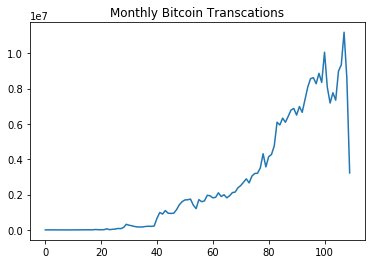

In [3]:
# import plotting library
import matplotlib.pyplot as plt

# plot monthly bitcoin transactions
plt.plot(transactions_per_month.transactions)
plt.title("Monthly Bitcoin Transcations")

Pretty cool, huh? :)

As you can see, common table expressions let you shift a lot of your data cleaning into SQL. That's an especially good thing in the case of BigQuery because it lets you take advantage of BigQuery's parallelization, which means you'll get your results more quickly.

# Scavenger hunt
___

> **Important note**: Today's dataset is bigger than the ones we've used previously, so your queries will be more than 1 Gigabyte. You can still run them by setting the "max_gb_scanned" argument in the `query_to_pandas_safe()` function to be large enough to run your query, or by using the `query_to_pandas()` function instead.

Now it's your turn! Here are the questions I would like you to get the data to answer. Practice using at least one alias in each query. 

* How many Bitcoin transactions were made each day in 2017?
    * You can use the "timestamp" column from the "transactions" table to answer this question. You can check the [notebook from Day 3](https://www.kaggle.com/rtatman/sql-scavenger-hunt-day-3/) for more information on timestamps.
* How many transactions are associated with each merkle root?
    * You can use the "merkle_root" and "transaction_id" columns in the "transactions" table to answer this question. 
    * Note that the earlier version of this question asked "How many *blocks* are associated with each merkle root?", which would be one block for each root. Apologies for the confusion!

In order to answer these questions, you can fork this notebook by hitting the blue "Fork Notebook" at the very top of this page (you may have to scroll up). "Forking" something is making a copy of it that you can edit on your own without changing the original.

In [5]:
# How many Bitcoin transactions were made each day in 2017?

query = """WITH time AS
            (
                SELECT TIMESTAMP_MILLIS(timestamp) AS trans_time,
                    transaction_id
                FROM `bigquery-public-data.bitcoin_blockchain.transactions`
            )

            SELECT COUNT(transaction_id) AS transactions,
                EXTRACT(YEAR FROM trans_time) AS year
            FROM time
            GROUP BY year
            HAVING year = 2017
"""

total_transactions_2017 = bitcoin_blockchain.query_to_pandas_safe(query, max_gb_scanned=21)

In [6]:
total_transactions_2017

,transactions,year
0,104063229,2017


In [11]:
# additional try - transactions by years

# How many Bitcoin transactions were made each day in 2017?

query = """WITH time AS
            (
                SELECT TIMESTAMP_MILLIS(timestamp) AS trans_time,
                    transaction_id
                FROM `bigquery-public-data.bitcoin_blockchain.transactions`
            )

            SELECT COUNT(transaction_id) AS transactions,
                EXTRACT(YEAR FROM trans_time) AS year
            FROM time
            GROUP BY year
            ORDER BY year
"""

yearly_transactions = bitcoin_blockchain.query_to_pandas_safe(query, max_gb_scanned=50)

In [14]:
yearly_transactions.year.unique()

array([2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018])

Text(0.5,1,'Yearly Bitcoin Transactions\n(2009-2017)')

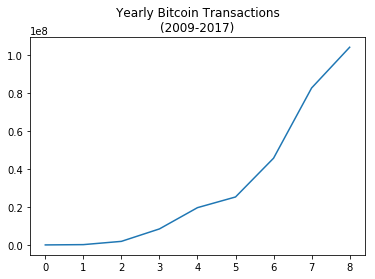

In [18]:
# visualize except for current year(2018)
plt.plot(yearly_transactions.transactions[:-1])
plt.title("Yearly Bitcoin Transactions\n(2009-2017)")


In [9]:
# How many transactions are associated with each merkle root?

query = """SELECT merkle_root,
                COUNT(transaction_id) AS transactions
            FROM `bigquery-public-data.bitcoin_blockchain.transactions`
            GROUP BY merkle_root
"""

transactions_each_merkle_root = bitcoin_blockchain.query_to_pandas_safe(query,
                                                                       max_gb_scanned = 50)

In [10]:
transactions_each_merkle_root

,merkle_root,transactions
0,e0f0d5c7f912f6c096d1d307101f13f928255fad3751ff...,256
1,141cfd72cef2b19c61c8592a834868688aa547ae2a4bf4...,256
2,daf3f627e7af360ae1a734b9e546595c74f919d8617f0d...,256
3,523062dec235486f7bfbc718f984c67665730d5f878ec4...,256
4,98772bd0cca1e7a990e8c3aeda54f963445674410ed9df...,256
5,2cf06a86ece781b7ae1ee7d84d21e16fd72d1367e25427...,256
6,2d7d8f2285edfb688d2c5392f1ae063ecfc9f136cc3ed4...,256
7,3416dbeec4515f5105f2583754c766dbb3e70ce864a7e7...,256
8,934fa400903aab9e5906bcb456dea27cddd053e9d50f4d...,256
9,94be81f0607afbc956106caa80baf86eeb6a9092e4cd0b...,256


In [22]:
# check further info on dataset to find more questions
bitcoin_blockchain.list_tables()

['blocks', 'transactions']

In [26]:
# 'blocks' table head
bitcoin_blockchain.head('blocks')

,block_id,previous_block,merkle_root,timestamp,difficultyTarget,nonce,version,work_terahash,work_error,transactions,row_number
0,000000000000000c507fa3bde0381b8045967290cd0f68...,0000000000000010cd9f3bb06c2e3a3bf3d2b6c032ffd1...,872878444faea5649fe8ef5a3b71e680090e6eb72c71cb...,1380933233000,421321760,1589157897,2,6391833,None,[{'transaction_id': 'cf37d4350927e83daa11cbc5d...,1
1,00000000000000000154f4a658376246e7db6a9a5f0f10...,000000000000000002118b8c7b1cbcd9a3382b10f120c9...,ffa60819fbc1d4f9314dd300cf2d729d775ca95d052bdb...,1485540376000,402836551,2586419874,536870912,16877901139,None,[{'transaction_id': '556169bc99e6aac04861bb9fd...,1
2,000000000527388711b6d23053ac1b8d7e37977cc9ef51...,0000000007654145fb3be342decb689190706c01c659c7...,65b0e15e796e3d7152ce06aed11b4810fb398910c005df...,1272453460000,471225455,39392850,1,0,None,[{'transaction_id': '65b0e15e796e3d7152ce06aed...,1
3,000000000000000000112946998aac5b3699b48e7fe320...,000000000000000006223890248011e5b67677b14c7484...,69e112a0fbacd4416125dfef9c43492fa96b2e4150cb59...,1457111979000,403093919,2531604712,4,7022020257,None,[{'transaction_id': '330e0b765fc9a81ea0c687421...,1
4,000000008176125447506e846d6be713bba9c2e743fc03...,00000000ee447ae94f067933bd06693246a12e1986d18c...,261bb32d4c98ffbbf2b7c7d91d6f8635ccfe2275c8af51...,1238207596000,486604799,405420087,1,0,None,[{'transaction_id': '261bb32d4c98ffbbf2b7c7d91...,1


In [28]:
# 'transactions' data sample
bitcoin_blockchain.head('blocks').transactions[0]

[{'inputs': [{'input_pubkey_base58': '',
    'input_pubkey_base58_error': None,
    'input_script_bytes': b'\x03z\xfe\x03\x06/P2SH/\x04k^OR\x08\xe8\x13\x00\xfd\x00-\xaf}.R,\xfa\xbemm\xc53\x13>\x18\x18*\x03\xc1b\r\xff\xed\xff\x17\xce\xf9\r\xe5\x8c\x06\xa4\xb0\xa4\xc7"\x8a\xcd\xe3=eT\x04\x00\x00\x00\x00\x00\x00\x00',
    'input_script_string': 'PUSHDATA(3)[7afe03] PUSHDATA(6)[2f503253482f] PUSHDATA(4)[6b5e4f52] PUSHDATA(8)[e81300fd002daf7d] PUSHDATA(46)[522cfabe6d6dc533133e18182a03c1620dffedff17cef90de58c06a4b0a4c7228acde33d65540400000000000000]',
    'input_script_string_error': None,
    'input_sequence_number': 0}],
  'outputs': [{'output_pubkey_base58': '1CjPR7Z5ZSyWk6WtXvSFgkptmpoi4UM9BC',
    'output_pubkey_base58_error': None,
    'output_satoshis': 2501155460,
    'output_script_bytes': b'v\xa9\x14\x80\xad\x90\xd4\x03X\x1f\xa3\xbfF\x08j\x91\xb2\xd9\xd4\x12]\xb6\xc1\x88\xac',
    'output_script_string': 'DUP HASH160 PUSHDATA(20)[80ad90d403581fa3bf46086a91b2d9d4125db6c1] EQUALVERIF

In [27]:
# 'transactions' table head
bitcoin_blockchain.head('transactions')

,timestamp,transaction_id,inputs,outputs,block_id,previous_block,merkle_root,nonce,version,work_terahash,work_error
0,1494614106000,97de418a71717df1d5374e0a2df8c447feedc6525c9160...,[{'input_script_bytes': b'G0D\x02 <\x97E\xa5\x...,"[{'output_satoshis': 7950753, 'output_script_b...",000000000000000000aa2ebdf2c19d0dfb93f530225e4c...,000000000000000000f74d7f56c41759bd2c0e4d36d286...,796a4b71fe777b37a29f55496eef6a14dc98a2d16e3787...,1198666500,536870912,24050933704,None
1,1487457855000,bd419d324e1127cba489653e825c5a4ce01bc3feaf4aa7...,"[{'input_script_bytes': b""G0D\x02 9\xb6v\x96'\...","[{'output_satoshis': 2010795, 'output_script_b...",0000000000000000015883638e16b25b44b21ca6576147...,0000000000000000009d32692f33a5709e00f235f1659b...,53050fd4e48ff443f2ed832dc4e41f5a424cc391c4db69...,3965297029,536870912,18931641524,None
2,1508953696000,a635f65a50fd2cacc374be5c00ade5957019b9787d9f94...,[{'input_script_bytes': b'H0E\x02!\x00\xe3X\xc...,"[{'output_satoshis': 958557, 'output_script_by...",0000000000000000000d68a881a42304e328abd4cf84ef...,000000000000000000c451ca46b1dc82252dd13d049271...,698906f92e832d859c4e3a14d345a2f1615eed829165bd...,1400909596,536870912,51402639154,None
3,1491724388000,00c28ee4a6f13be72687fd6f53dc41dff3756421f2d3ac...,[{'input_script_bytes': b'G0D\x02 R\x02\xe6\x9...,"[{'output_satoshis': 432776, 'output_script_by...",0000000000000000011036f9a6acb445b744241aeb5e7e...,0000000000000000019a6bd14aa843dcdbd410398fd2a2...,d0b533a799c9a330ade57523f7d5334de9f3b2a92f182f...,1730907491,805306368,21459527231,None
4,1361497675000,434b2238b3aa5764b9c8bbce4006e8c431d40c1db4c1a7...,[{'input_script_bytes': b'I0F\x02!\x00\xf2\xdb...,"[{'output_satoshis': 1, 'output_script_bytes':...",0000000000000381e22ef7d0cd572b688c976caaf37c06...,0000000000000174a8d160523918ae0953692d060bfce6...,ce8aed196a89dcd746c772f2df0d92bc76c4ec8891674f...,2520645360,2,156812,None


## Simple research on some terminology / domain knowledge
Diagram graphic source : [Wikipedia](https://en.wikipedia.org/wiki/Merkle_tree)<br>
Definition(text) source : https://bitcoin.org/en/glossary/

![merkle-tree-wiki](https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Hash_Tree.svg/1200px-Hash_Tree.svg.png)

### `Merkle Tree`
* A tree constructed by hashing paired data (the leaves), then pairing and hashing the results until a single hash remains, the [merkle root](https://bitcoin.org/en/glossary/merkle-root). **In Bitcoin, the leaves are almost always transactions from a single [block](https://bitcoin.org/en/glossary/block)**.

### `Merkle Root`
* The root [node](https://bitcoin.org/en/glossary/node) of a [merkle tree](https://bitcoin.org/en/glossary/merkle-tree), a descendant of all the hashed pairs in the tree. [Block headers](https://bitcoin.org/en/glossary/block-header) must include a valid [merkle root](https://bitcoin.org/en/glossary/merkle-root) descended from all transactions in that block.

### `Merkle Block`
* A partial [merkle tree](https://bitcoin.org/en/glossary/merkle-tree) connecting transactions matching a [bloom filter](https://bitcoin.org/en/glossary/bloom-filter) to the [merkle root](https://bitcoin.org/en/glossary/merkle-root) of a [block](https://bitcoin.org/en/glossary/block).

In [ ]:
# For knowing some knowledge on basic structure of bitcoin merkle tree,
# we get to know that it may be useful to investigate merkle root

In [32]:
query = """SELECT merkle_root,
                COUNT(transaction_id) AS transactions,
                SUM(work_terahash) AS worked_terahash
            FROM `bigquery-public-data.bitcoin_blockchain.transactions`
            GROUP BY merkle_root
            ORDER BY transactions DESC
            LIMIT 10
"""

merkle_root_performance = bitcoin_blockchain.query_to_pandas_safe(query,
                                                                max_gb_scanned = 50)

In [33]:
merkle_root_performance

,merkle_root,transactions,worked_terahash
0,dc1bde29f6912ba825138118676988a0e7f839054155db...,12239,27481087799323
1,03ef22104e4561d1c8198015157aa80ec08f1aaef676bf...,9647,21661087833979
2,52461d6e9d181204112ee8ca440921d5df88763ddb6e86...,6451,13687943141211
3,60f1b83982cd4588a8a99b66bb24c5e6d7bb15d34c6a90...,6144,13478379737088
4,73733e699f12f312843b99b309d65ac499c57507d2120f...,6084,13346754934968
5,c59fd39bd08b42ff1d6c175439af2dc74942bb708e517b...,5973,12673707081453
6,e3d2085f137f83e14e572784ad353ed9bcc02a65e3946a...,5946,13044017890092
7,012c4d5cb8c1fb95325d46f6c47634300b89ef4f99fe56...,5944,13039630396688
8,37a3c1b5d1da8450c0b7c2ed1768cc9d8ccd8c5e59fb59...,5937,13024274169774
9,e395b6a84f591ef69be39110e20ffc7c573e5186cf7f09...,5866,12868518153932


In [54]:
# Top 10 merkle_root in 2017 in terms of transactions
query = """
            WITH merkle_root_performance AS (
            
                SELECT merkle_root,
                    EXTRACT(YEAR FROM TIMESTAMP_MILLIS(timestamp)) AS year,
                    COUNT(transaction_id) AS transactions_by_year,
                    SUM(work_terahash) AS worked_terahash_by_year
                FROM `bigquery-public-data.bitcoin_blockchain.transactions`
                GROUP BY merkle_root, year
            )
            
            SELECT * 
            FROM merkle_root_performance
            WHERE year = 2017
            ORDER BY transactions_by_year DESC
            LIMIT 10
"""

top10_merkle_root_2017 = bitcoin_blockchain.query_to_pandas_safe(query,
                                                                max_gb_scanned = 50)
top10_merkle_root_2017

,merkle_root,year,transactions_by_year,worked_terahash_by_year
0,f1841afec50a9ef77f91e2bef1fafe8eb4e844dc814f76...,2017,4667,92360841063738
1,b9d93c145ec7ce187aaf588f9852e9b5610be64c6d4bf7...,2017,4636,111500128651744
2,3ddc9474cbdb826a3c4153f68b7dfa06e3d2192ccb7272...,2017,4441,84075420008084
3,3571f7db89b95f00a5988fca3ac30a9006a57d786f12f0...,2017,4427,83810377026748
4,f7d50cd1b78f3ad24e3f4e4deac132de35e35b0640eaf6...,2017,4342,254451518176830
5,2fb93083d67f5ebf97349c62b205c05f99cb3f611bc18e...,2017,4311,103683575197944
6,8c9aea90a8b99d7acc365cc886742b17ba96eefd893e82...,2017,4203,262266971041575
7,a42f6e939547eee615aad726bc67cee398ac9cf4665248...,2017,4176,93412554729984
8,9cedc72846aa43ff9a2ba5f152ef88f1ee7a6bb712479b...,2017,4156,99955680473824
9,fb78e1ea427d76555698625fb6a074f4ca464dbf634f5a...,2017,4148,239979029560044


In [53]:
# Top 10 merkle_root in 2018 in terms of transactions
query = """
            WITH merkle_root_performance AS (
            
                SELECT merkle_root,
                    EXTRACT(YEAR FROM TIMESTAMP_MILLIS(timestamp)) AS year,
                    COUNT(transaction_id) AS transactions_by_year,
                    SUM(work_terahash) AS worked_terahash_by_year
                FROM `bigquery-public-data.bitcoin_blockchain.transactions`
                GROUP BY merkle_root, year
            )
            
            SELECT * 
            FROM merkle_root_performance
            WHERE year = 2018
            ORDER BY transactions_by_year DESC
            LIMIT 10
"""

top10_merkle_root_2018 = bitcoin_blockchain.query_to_pandas_safe(query,
                                                                max_gb_scanned = 50)
top10_merkle_root_2018

,merkle_root,year,transactions_by_year,worked_terahash_by_year
0,97df8b0379a2d1d7e2b5225bf74e5c35a3311912ec61f5...,2018,4109,340812560059930
1,8216baba646b9119bbf88558e688cdc9193a60ecbc0c7c...,2018,4079,338324271716830
2,5a41d6652f1dc212f8f7f0eea00dfd6af96c7e60245e9b...,2018,3920,325136343498400
3,37de0aade1e06a7f5bd9a60b50d8e8be6a9c9b8addb956...,2018,3783,361983117271386
4,721ca820e2e1fa18befdc169aadbc6f5b4db348c6fbd59...,2018,3771,312777844727670
5,4153fe1c4291d361eebc3ffe4003b4438add649ad6e4fa...,2018,3759,311782529390430
6,92925feb4d587baf406f8417e0f7e70b43928fef085fa4...,2018,3757,311616643500890
7,d9a366fe92ff25a6c3bd02d7e1e8af5560341bfdc01a83...,2018,3693,306308295035610
8,2c81f6f398dbab158ed44c676e20f98f0180673474ec5c...,2018,3634,301414661294180
9,4c6230a52aa8d10f9837df919bace3565e1f3b7ef27b78...,2018,3598,402267282913776


In [ ]:
# One last question ... 
# values in 'work_terahash' column from 'transactions' table are cumulative?
# we can check whether it is or not sorting by timestamp.

In [61]:
query = """
            SELECT merkle_root,
                TIMESTAMP_MILLIS(timestamp) AS timestamp_millis,
                EXTRACT(YEAR FROM TIMESTAMP_MILLIS(timestamp)) AS timestamp_year,
                work_terahash
            FROM `bigquery-public-data.bitcoin_blockchain.transactions`
            WHERE EXTRACT(YEAR FROM TIMESTAMP_MILLIS(timestamp)) = 2016
            ORDER BY timestamp_millis, timestamp_year
            LIMIT 10
"""

terahash_cum_check = bitcoin_blockchain.query_to_pandas_safe(query,
                                                            max_gb_scanned = 50)
terahash_cum_check

,merkle_root,timestamp_millis,timestamp_year,work_terahash
0,aaa6f766ac4982505d0ca710ca5bbbe2716a46eb8eb2ef...,2016-01-01 00:03:21+00:00,2016,4461694745
1,aaa6f766ac4982505d0ca710ca5bbbe2716a46eb8eb2ef...,2016-01-01 00:03:21+00:00,2016,4461694745
2,aaa6f766ac4982505d0ca710ca5bbbe2716a46eb8eb2ef...,2016-01-01 00:03:21+00:00,2016,4461694745
3,aaa6f766ac4982505d0ca710ca5bbbe2716a46eb8eb2ef...,2016-01-01 00:03:21+00:00,2016,4461694745
4,aaa6f766ac4982505d0ca710ca5bbbe2716a46eb8eb2ef...,2016-01-01 00:03:21+00:00,2016,4461694745
5,aaa6f766ac4982505d0ca710ca5bbbe2716a46eb8eb2ef...,2016-01-01 00:03:21+00:00,2016,4461694745
6,aaa6f766ac4982505d0ca710ca5bbbe2716a46eb8eb2ef...,2016-01-01 00:03:21+00:00,2016,4461694745
7,aaa6f766ac4982505d0ca710ca5bbbe2716a46eb8eb2ef...,2016-01-01 00:03:21+00:00,2016,4461694745
8,aaa6f766ac4982505d0ca710ca5bbbe2716a46eb8eb2ef...,2016-01-01 00:03:21+00:00,2016,4461694745
9,aaa6f766ac4982505d0ca710ca5bbbe2716a46eb8eb2ef...,2016-01-01 00:03:21+00:00,2016,4461694745


In [62]:
query = """
            SELECT merkle_root,
                TIMESTAMP_MILLIS(timestamp) AS timestamp_millis,
                EXTRACT(YEAR FROM TIMESTAMP_MILLIS(timestamp)) AS timestamp_year,
                work_terahash
            FROM `bigquery-public-data.bitcoin_blockchain.transactions`
            WHERE EXTRACT(YEAR FROM TIMESTAMP_MILLIS(timestamp)) = 2016
            ORDER BY timestamp_millis DESC, timestamp_year DESC
            LIMIT 10
"""

terahash_cum_check = bitcoin_blockchain.query_to_pandas_safe(query,
                                                            max_gb_scanned = 50)
terahash_cum_check

,merkle_root,timestamp_millis,timestamp_year,work_terahash
0,7ee4b63a26ed4a41e22ac7855836d7ede9e59b5d2c9be9...,2016-12-31 23:44:04+00:00,2016,13644821101
1,7ee4b63a26ed4a41e22ac7855836d7ede9e59b5d2c9be9...,2016-12-31 23:44:04+00:00,2016,13644821101
2,7ee4b63a26ed4a41e22ac7855836d7ede9e59b5d2c9be9...,2016-12-31 23:44:04+00:00,2016,13644821101
3,7ee4b63a26ed4a41e22ac7855836d7ede9e59b5d2c9be9...,2016-12-31 23:44:04+00:00,2016,13644821101
4,7ee4b63a26ed4a41e22ac7855836d7ede9e59b5d2c9be9...,2016-12-31 23:44:04+00:00,2016,13644821101
5,7ee4b63a26ed4a41e22ac7855836d7ede9e59b5d2c9be9...,2016-12-31 23:44:04+00:00,2016,13644821101
6,7ee4b63a26ed4a41e22ac7855836d7ede9e59b5d2c9be9...,2016-12-31 23:44:04+00:00,2016,13644821101
7,7ee4b63a26ed4a41e22ac7855836d7ede9e59b5d2c9be9...,2016-12-31 23:44:04+00:00,2016,13644821101
8,7ee4b63a26ed4a41e22ac7855836d7ede9e59b5d2c9be9...,2016-12-31 23:44:04+00:00,2016,13644821101
9,7ee4b63a26ed4a41e22ac7855836d7ede9e59b5d2c9be9...,2016-12-31 23:44:04+00:00,2016,13644821101


In [63]:
# Then we can calculate the amount of terahash worked for each year.

query = """
            SELECT EXTRACT(YEAR FROM TIMESTAMP_MILLIS(timestamp)) AS timestamp_year,
                (MAX(work_terahash) - MIN(work_terahash)) AS yearly_worked_terahash
            FROM `bigquery-public-data.bitcoin_blockchain.transactions`
            GROUP BY timestamp_year
            ORDER BY timestamp_year
"""

terahash_worked_by_year = bitcoin_blockchain.query_to_pandas_safe(query,
                                                            max_gb_scanned = 50)
terahash_worked_by_year

,timestamp_year,yearly_worked_terahash
0,2009,0
1,2010,622
2,2011,80502
3,2012,97883
4,2013,50593529
5,2014,1694821323
6,2015,2716152384
7,2016,9183126356
8,2017,66805674056
9,2018,43017707052


In [66]:
# normalize two data - yearly transactions & yearly worked terahash
# to visualize the changing trend and compare with each other.

yearly_terahash = terahash_worked_by_year.yearly_worked_terahash
yearly_transactions = yearly_transactions.transactions

norm_yearly_terahash = (yearly_terahash - yearly_terahash.mean())/yearly_terahash.std()
norm_yearly_transactions = (yearly_transactions - yearly_transactions.mean())/yearly_transactions.std()


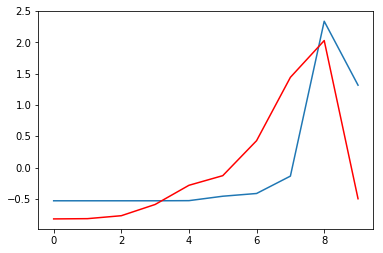

In [67]:
# Visualize both information at once

plt.plot(norm_yearly_terahash)
plt.plot(norm_yearly_transactions, c='r')

Please feel free to ask any questions you have in this notebook or in the [Q&A forums](https://www.kaggle.com/questions-and-answers)! 

Also, if you want to share or get comments on your kernel, remember you need to make it public first! You can change the visibility of your kernel under the "Settings" tab, on the right half of your screen.